# Garbage Classification
Dataset take from [Kaggle](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification) including 6 class and self-collection dataset. 
This notebook will solve Garbage Classification on total 8 class:

* Glass
* Metal
* Paper
* Cardboard
* Plastic
* Nilon
* Facemask
* Danger

Let's go using CNNs from Scratch.

## Prepare Data
___

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL
import glob
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
data_dir = pathlib.Path("/content/drive/MyDrive/PBL5-Data/Garbage Data Aug")

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3643


In [ ]:
batch_size = 32
img_height = 160
img_width = 160

In [ ]:
# path contains link data
new_path = '/content/drive/MyDrive/PBL5-Data/Garbage Data Aug Stratified_T/'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  new_path + '/Train',
  seed=70,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2914 files belonging to 8 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  new_path + '/Val',
  seed=70,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 729 files belonging to 8 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'danger', 'facemask', 'glass', 'metal', 'nilon', 'paper', 'plastic']


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  new_path + '/Test',
  seed=70,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 339 files belonging to 8 classes.


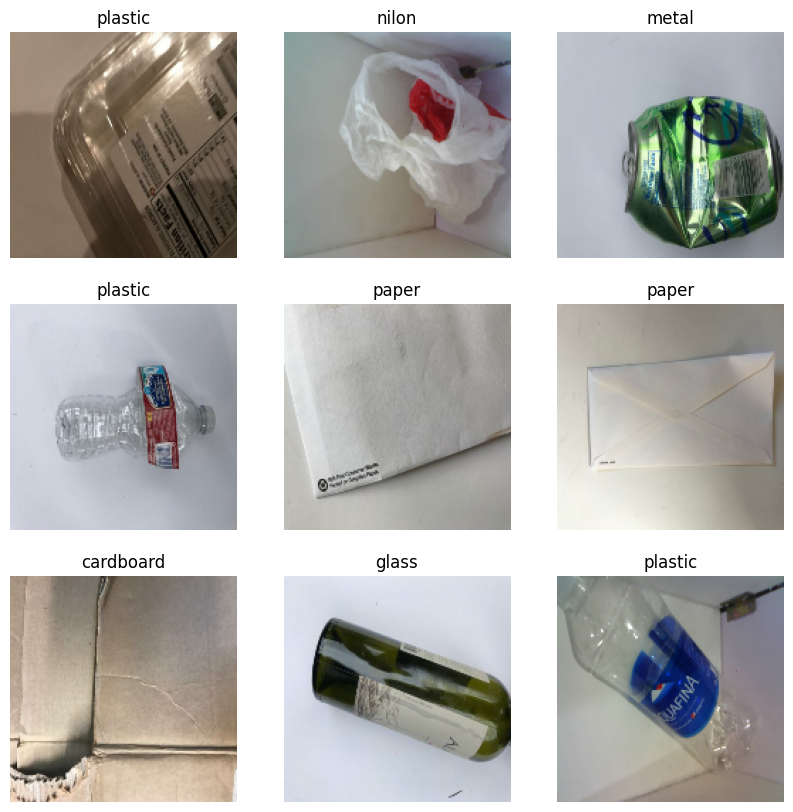

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

num_classes = len(class_names)

(32, 160, 160, 3)
(32,)


## Reuse function
___


### 1. Draw process

In [ ]:
# epochs: epochs that model stop at
def loss_acc(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

### 2. Model compile

In [ ]:
# file_name: path saving model checkpoint
# sfe: apply early stopping start from which epochs
def model_compile(model, file_name, sfe):
  callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', start_from_epoch= sfe), # mode in {'auto', 'min', 'max'}, patience: sau bao nhiêu epoch không có sự cải thiện thì dừng lại, mode='min': chỉ dừng lại khi loss không giảm dần, mode='max': chỉ dừng lại khi loss không tăng dần
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='min'), # factor: giảm learning rate bằng factor, patience: số lần không có sự cải thiện nào thì dừng lại, verbose: thông báo
    ModelCheckpoint(filepath="/content/drive/MyDrive/PBL5-Data/training1/"+file_name,
                                              save_weights_only=True,
                                              verbose=0)
  ] 

  model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate = 0.0005),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  model.summary()
  return model, callbacks

### 3. Save load history

In [ ]:
# save history of model to reuse in future
def save_hist(history, file_name):
  hist_df_new = pd.DataFrame(history.history)
  hist_csv_file = '/content/drive/MyDrive/PBL5-Data/history/'+file_name
  with open(hist_csv_file, mode='w') as f:
      hist_df_new.to_csv(f)
# load hist from saved hist and combine with new hist
def load_continue_hist(file_name, new_hist):
  hist_df = pd.read_csv("/content/drive/MyDrive/PBL5-Data/history/"+file_name)
  return pd.concat([hist_df,pd.DataFrame(new_hist.history)], axis = 0, ignore_index = True)


### 4. Evaluate 

In [ ]:
# evaluate loss, acc on train/val/test and draw confusionmatrix of test dataset with inference time
def evaluate_conma(model, ds = [train_ds, val_ds, test_ds], class_names = class_names):
  # display loss, acc of train_ds, val_ds, test_ds
  loss = []
  acc = []
  for eva in ds:
    result = model.evaluate(eva)
    loss.append(result[0])
    acc.append(result[1])
  dt = pd.DataFrame(columns = ["train_ds", "val_ds", "test_ds"], index = ["accuracy", "loss"])
  dt.loc['loss'] = loss
  dt.loc['accuracy'] = acc
  display(dt)
  # display confusion matrix for testing fase
  y_true = []
  y_pred = []
  test_start = time.time()
  for x, y in test_ds.unbatch():
      y_true.append(y)
      pred = model.predict(tf.expand_dims(x,0), verbose = 0)
      score = tf.nn.softmax(pred[0])
      y_pred.append(np.argmax(score))
  test_finish = time.time()
  test_inference = test_finish - test_start
  conf_mat = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(conf_mat, display_labels = class_names)
  disp.plot(xticks_rotation= 'vertical')
  print('Inference_time: ', test_inference)

## CNNs from Scratch and steps to improve
___

###1. Plain model:

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model, callbacks = model_compile(model, "checkpoint_plain", 5)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 64)       

In [ ]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks = callbacks
)

Epoch 1/30
89/89 [==============================] - 28s 121ms/step - loss: 1.6534 - accuracy: 0.3834 - val_loss: 1.3167 - val_accuracy: 0.5352 - lr: 5.0000e-04
Epoch 2/30
89/89 [==============================] - 9s 98ms/step - loss: 1.2512 - accuracy: 0.5712 - val_loss: 1.0522 - val_accuracy: 0.6310 - lr: 5.0000e-04
Epoch 3/30
89/89 [==============================] - 10s 98ms/step - loss: 0.9971 - accuracy: 0.6705 - val_loss: 0.9576 - val_accuracy: 0.6310 - lr: 5.0000e-04
Epoch 4/30
89/89 [==============================] - 7s 68ms/step - loss: 0.8317 - accuracy: 0.7237 - val_loss: 0.8784 - val_accuracy: 0.6479 - lr: 5.0000e-04
Epoch 5/30
89/89 [==============================] - 6s 63ms/step - loss: 0.7086 - accuracy: 0.7618 - val_loss: 0.8222 - val_accuracy: 0.6958 - lr: 5.0000e-04
Epoch 6/30
89/89 [==============================] - 7s 75ms/step - loss: 0.5640 - accuracy: 0.8097 - val_loss: 0.7906 - val_accuracy: 0.7352 - lr: 5.0000e-04
Epoch 7/30
89/89 [==============================]

In [ ]:
# save model
model.save('/content/drive/MyDrive/PBL5-Data/training1/plain_stratify_after')

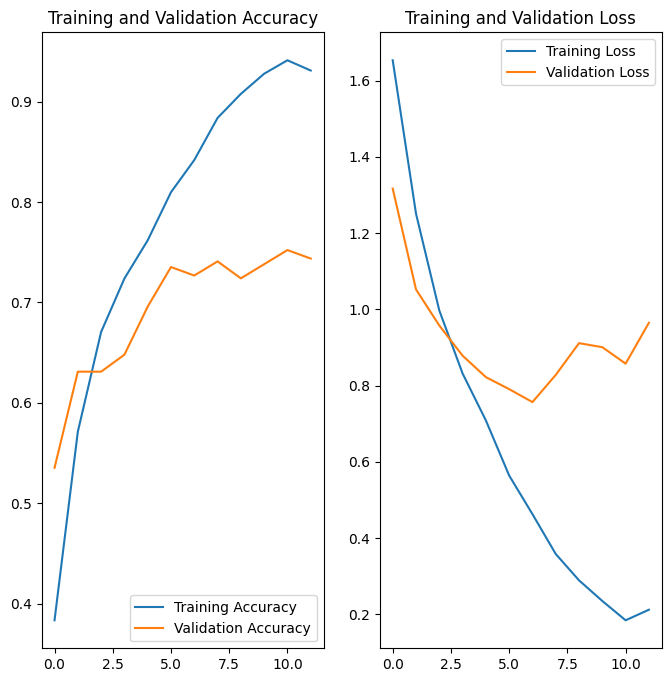

In [ ]:
loss_acc(history, 12)

In [ ]:
# save hist
save_hist(history, "hist_plain_after")

12/12 [==============================] - 0s 11ms/step - loss: 1.0564 - accuracy: 0.7268


,train_ds,val_ds,test_ds
accuracy,0.96124,0.743662,0.726761
loss,0.134777,0.964777,1.056373


Inference_time:  20.412784814834595


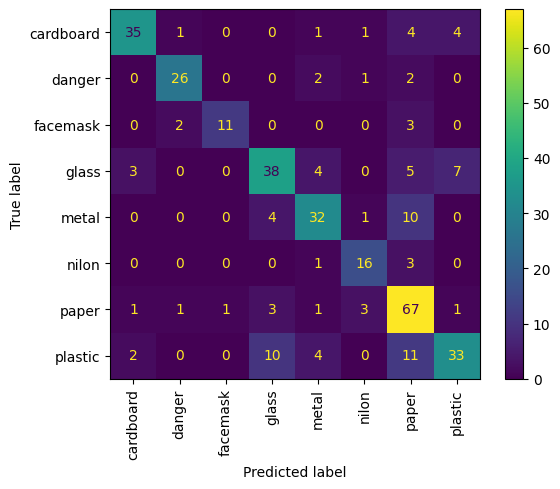

In [ ]:
evaluate_conma(model)

*The convergence of training accuracy and loss is significant, whearas that of validation ones is almost stable, not changes through epochs, even validation loss tends to increase*

**=> overfit cause of not having much data**

###2. Data Augmentation:

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.3),
  ]
)

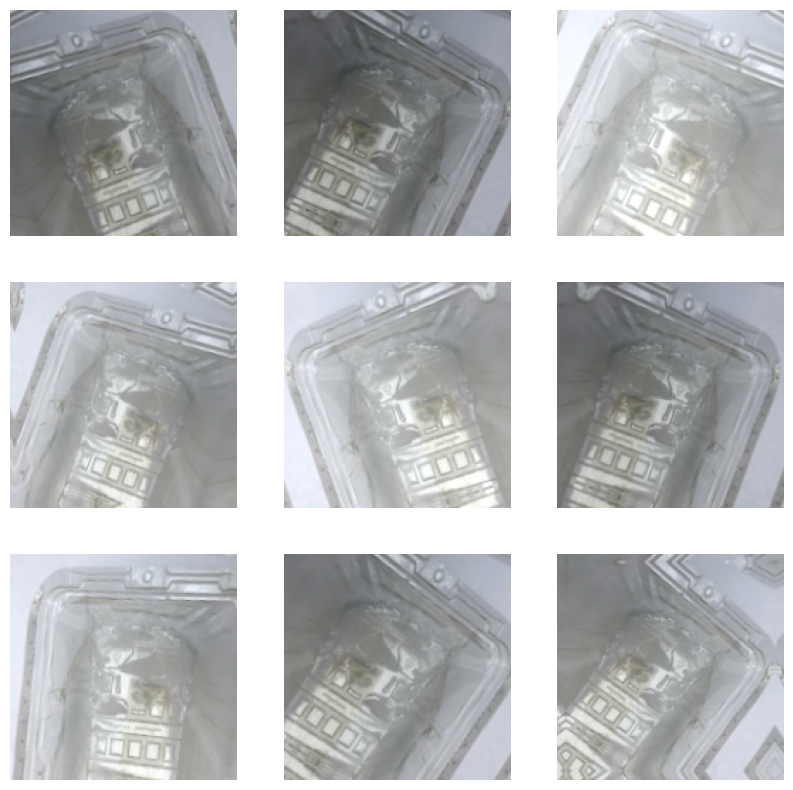

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model, callbacks = model_compile(model, "checkpoint_aug_only", 10 )

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 80, 80, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 40, 40, 32)       0         
 g2D)                                                 

In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = callbacks
)

Epoch 1/50
77/77 [==============================] - 10s 86ms/step - loss: 1.7705 - accuracy: 0.3051 - val_loss: 1.5845 - val_accuracy: 0.3750 - lr: 5.0000e-04
Epoch 2/50
77/77 [==============================] - 7s 83ms/step - loss: 1.5774 - accuracy: 0.3951 - val_loss: 1.5105 - val_accuracy: 0.4638 - lr: 5.0000e-04
Epoch 3/50
77/77 [==============================] - 8s 101ms/step - loss: 1.4802 - accuracy: 0.4456 - val_loss: 1.4135 - val_accuracy: 0.5099 - lr: 5.0000e-04
Epoch 4/50
77/77 [==============================] - 7s 85ms/step - loss: 1.3733 - accuracy: 0.4842 - val_loss: 1.3046 - val_accuracy: 0.5230 - lr: 5.0000e-04
Epoch 5/50
77/77 [==============================] - 8s 100ms/step - loss: 1.3137 - accuracy: 0.5129 - val_loss: 1.4408 - val_accuracy: 0.4803 - lr: 5.0000e-04
Epoch 6/50
77/77 [==============================] - 8s 100ms/step - loss: 1.2578 - accuracy: 0.5355 - val_loss: 1.2852 - val_accuracy: 0.4770 - lr: 5.0000e-04
Epoch 7/50
77/77 [==============================

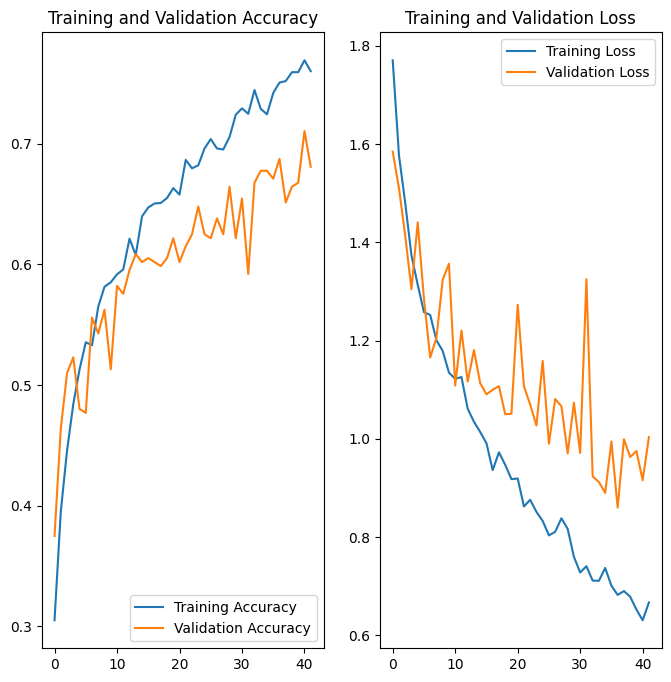

In [ ]:
loss_acc(history, 42)

10/10 [==============================] - 0s 10ms/step - loss: 0.8911 - accuracy: 0.6908


,train_ds,val_ds,test_ds
accuracy,0.755647,0.680921,0.690789
loss,0.659917,1.003508,0.891069


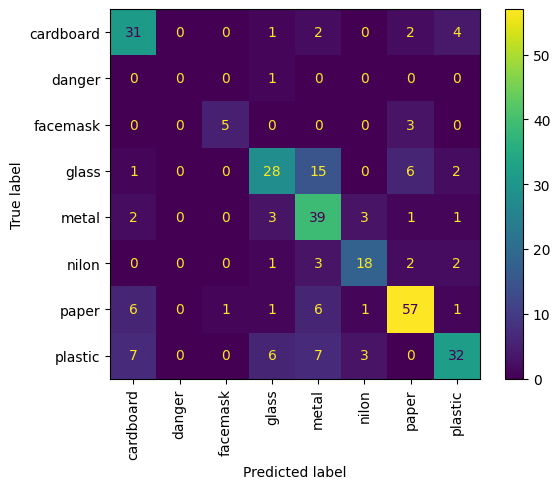

In [ ]:
evaluate_conma(model)

*Accuracy on training and validation is more improved (>72%). However, gap betwwen them is still wide and validation loss still tends to increase*

**=> overfit or model maybe more complex compare to training data**

###3. Augmentation + Dropout:

In [ ]:
hist_df_new = pd.DataFrame(history.history)

In [ ]:
hist_csv_file = '/content/drive/MyDrive/PBL5-Data/history/hist_aug_only_notES'
with open(hist_csv_file, mode='w') as f:
    hist_df_new.to_csv(f)

In [ ]:
hist_df = pd.read_csv("/content/drive/MyDrive/PBL5-Data/history/hist_aug_only") 

In [ ]:
hist_df = pd.concat([hist_df,pd.DataFrame(history.history)], axis = 0)

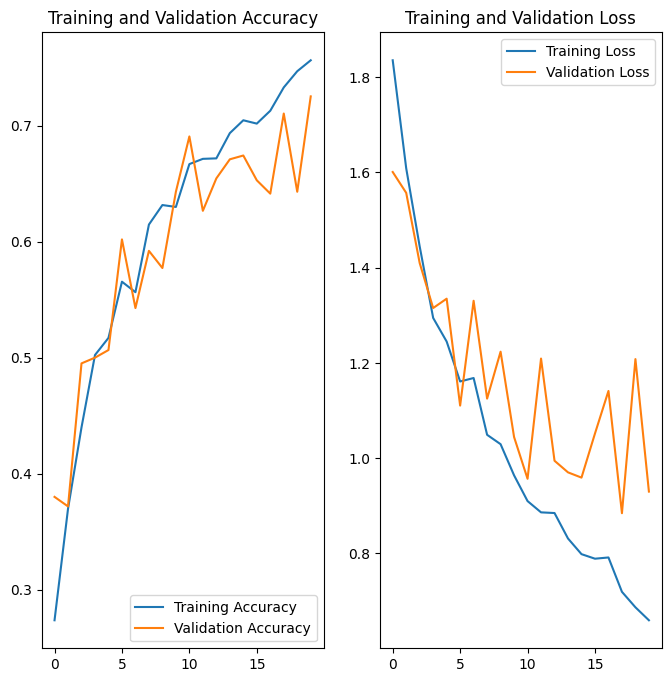

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*The model is more fit. However, accuray is not high enough and more fluctuate through training process*

**=> dropout has removed learning ability of model and number of training data, epochs is not high enough, so it is not stable through train**

###4. Augmentation + Dropout + Batch Normallize

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', name = 'conv_1'),
  layers.MaxPooling2D((2,2), strides = 2),
  layers.BatchNormalization(name = 'bn_conv_1'),
  layers.Conv2D(32, 3, padding='same', activation='relu', name = 'conv_2'),
  layers.MaxPooling2D((2,2), strides = 2),
  layers.BatchNormalization(name = 'bn_conv_2'),
  layers.Conv2D(64, 3, padding='same', activation='relu', name = 'conv_3'),
  layers.MaxPooling2D((2,2), strides = 2),
  layers.BatchNormalization(name = 'bn_conv_3'),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu', name = 'fc1'),
  layers.Dropout(0.1),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model, callbacks = model_compile(model, "checkpoint_aug_dropout_batchnorm_stratify_after_T", 40)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv_1 (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 80, 80, 16)       0         
 g2D)                                                            
                                                                 
 bn_conv_1 (BatchNormalizati  (None, 80, 80, 16)       64        
 on)                                                             
                                                                 
 conv_2 (Conv2D)             (None, 80, 80, 32)       

In [ ]:
epochs =100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = callbacks
)

Epoch 1/100
92/92 [==============================] - 12s 77ms/step - loss: 2.1764 - accuracy: 0.3222 - val_loss: 2.5736 - val_accuracy: 0.2195 - lr: 5.0000e-04
Epoch 2/100
92/92 [==============================] - 9s 94ms/step - loss: 1.6182 - accuracy: 0.4121 - val_loss: 2.4623 - val_accuracy: 0.2551 - lr: 5.0000e-04
Epoch 3/100
92/92 [==============================] - 8s 78ms/step - loss: 1.5540 - accuracy: 0.4382 - val_loss: 2.3054 - val_accuracy: 0.2908 - lr: 5.0000e-04
Epoch 4/100
92/92 [==============================] - 8s 85ms/step - loss: 1.5375 - accuracy: 0.4447 - val_loss: 2.2400 - val_accuracy: 0.3141 - lr: 5.0000e-04
Epoch 5/100
92/92 [==============================] - 9s 96ms/step - loss: 1.5015 - accuracy: 0.4423 - val_loss: 1.4996 - val_accuracy: 0.4650 - lr: 5.0000e-04
Epoch 6/100
92/92 [==============================] - 7s 75ms/step - loss: 1.3701 - accuracy: 0.4942 - val_loss: 1.2730 - val_accuracy: 0.5638 - lr: 5.0000e-04
Epoch 7/100
92/92 [==========================

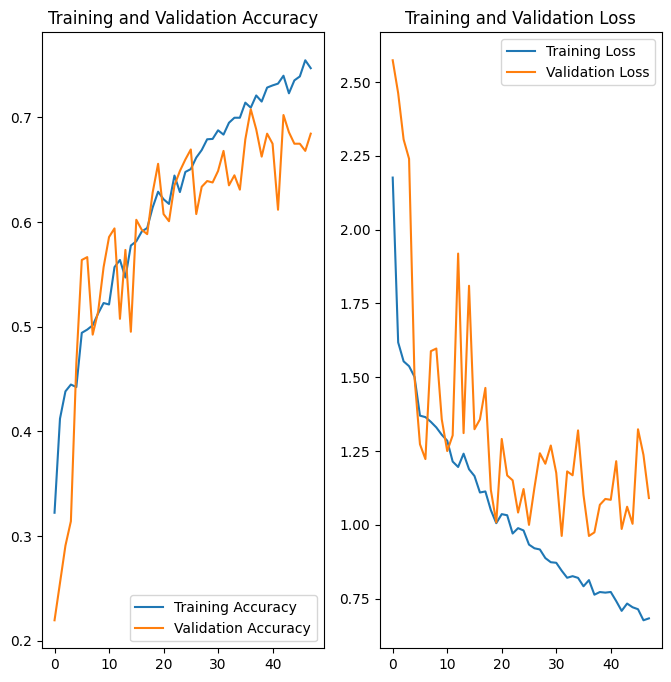

In [ ]:
loss_acc(history, 48)

In [ ]:
save_hist(history,"hist_aug_dropout_batchnorm_stratify_after_T")

10/10 [==============================] - 0s 13ms/step - loss: 0.8342 - accuracy: 0.7566


,train_ds,val_ds,test_ds
accuracy,0.78809,0.700658,0.756579
loss,0.544722,0.874667,0.834246


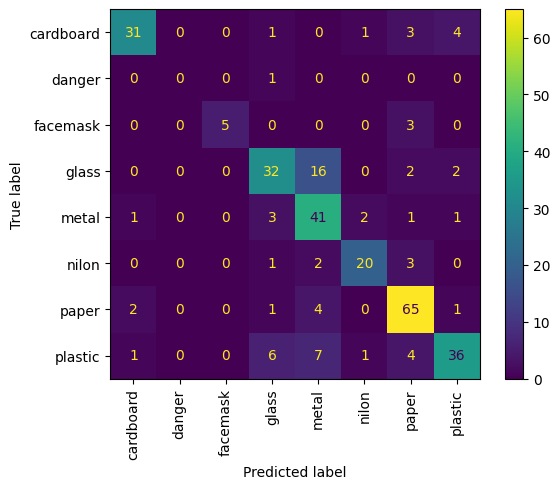

In [ ]:
evaluate_conma(model)

*The model is more fit, accuracy looks more improve: train accuracy ~80% and validation accuracy ~71%*

**=> Using combination of pre-approach and BatchNormallize which has ability to fix distribution input througout each layers improves not-fit problems and increase accuracy on model trianing on small dataset.**

### 5. Ensemble learning with boosting
#### *Run right after section 4 above*

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', name = 'conv_1'),
  layers.MaxPooling2D((2,2), strides = 2),
  layers.BatchNormalization(name = 'bn_conv_1'),
  layers.Conv2D(32, 3, padding='same', activation='relu', name = 'conv_2'),
  layers.MaxPooling2D((2,2), strides = 2),
  layers.BatchNormalization(name = 'bn_conv_2'),
  layers.Conv2D(64, 3, padding='same', activation='relu', name = 'conv_3'),
  layers.MaxPooling2D((2,2), strides = 2),
  layers.BatchNormalization(name = 'bn_conv_3'),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu', name = 'fc1'),
  layers.Dropout(0.1),
  layers.Dense(num_classes, name="outputs")
])


In [ ]:
model, callbacks = model_compile(model,"checkpoint_partialaug_T", 30)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv_1 (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 bn_conv_1 (BatchNormalizati  (None, 80, 80, 16)       64        
 on)                                                             
                                                                 
 conv_2 (Conv2D)             (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)      

In [ ]:
model.load_weights("/content/drive/MyDrive/PBL5-Data/training1/checkpoint_aug_dropout_batchnorm_stratify_after_T")

In [ ]:
epochs =100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = callbacks
)

Epoch 1/100
92/92 [==============================] - 16s 97ms/step - loss: 0.5598 - accuracy: 0.7938 - val_loss: 0.7480 - val_accuracy: 0.7654 - lr: 1.0486e-04
Epoch 2/100
92/92 [==============================] - 7s 74ms/step - loss: 0.4716 - accuracy: 0.8308 - val_loss: 0.6767 - val_accuracy: 0.7833 - lr: 1.0486e-04
Epoch 3/100
92/92 [==============================] - 8s 85ms/step - loss: 0.4483 - accuracy: 0.8360 - val_loss: 0.6618 - val_accuracy: 0.7805 - lr: 1.0486e-04
Epoch 4/100
92/92 [==============================] - 7s 75ms/step - loss: 0.3961 - accuracy: 0.8658 - val_loss: 0.7036 - val_accuracy: 0.7833 - lr: 1.0486e-04
Epoch 5/100
92/92 [==============================] - 8s 86ms/step - loss: 0.3705 - accuracy: 0.8614 - val_loss: 0.6246 - val_accuracy: 0.7846 - lr: 1.0486e-04
Epoch 6/100
92/92 [==============================] - 9s 91ms/step - loss: 0.3277 - accuracy: 0.8919 - val_loss: 0.6220 - val_accuracy: 0.7984 - lr: 1.0486e-04
Epoch 7/100
92/92 [==========================

In [ ]:
model.save("/content/drive/MyDrive/PBL5-Data/training1/aug_partial_stratify_after_T")

In [ ]:
# Create new history that combine history of previous model (4) and current history
new_history = load_continue_hist("hist_aug_dropout_batchnorm_stratify_after_T",history)
new_history

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,lr
0,0.0,2.176370,0.322237,2.573649,0.219479,0.000500
1,1.0,1.618181,0.412148,2.462272,0.255144,0.000500
2,2.0,1.553961,0.438229,2.305422,0.290809,0.000500
3,3.0,1.537529,0.444749,2.239957,0.314129,0.000500
4,4.0,1.501547,0.442347,1.499631,0.465021,0.000500
...,...,...,...,...,...,...
88,NaN,0.036494,0.990048,0.595898,0.857339,0.000043
89,NaN,0.029855,0.992450,0.596975,0.855967,0.000034
90,NaN,0.030517,0.992450,0.578603,0.855967,0.000034
91,NaN,0.032294,0.990048,0.601057,0.849108,0.000034


In [ ]:
# Save new_hist
hist_csv_file = '/content/drive/MyDrive/PBL5-Data/history/hist_partialaug_stratify_after_T'
with open(hist_csv_file, mode='w') as f:
    new_history.to_csv(f)

11/11 [==============================] - 2s 67ms/step - loss: 0.5935 - accuracy: 0.9263


,train_ds,val_ds,test_ds
accuracy,0.999314,0.849108,0.926254
loss,0.006514,0.615025,0.593496


Inference_time:  34.02493238449097


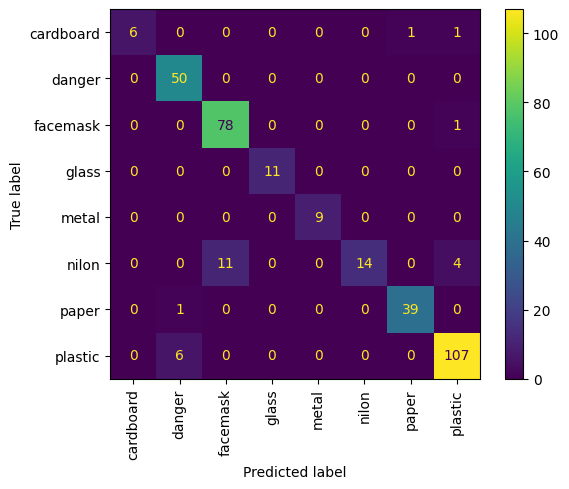

In [ ]:
evaluate_conma(model)

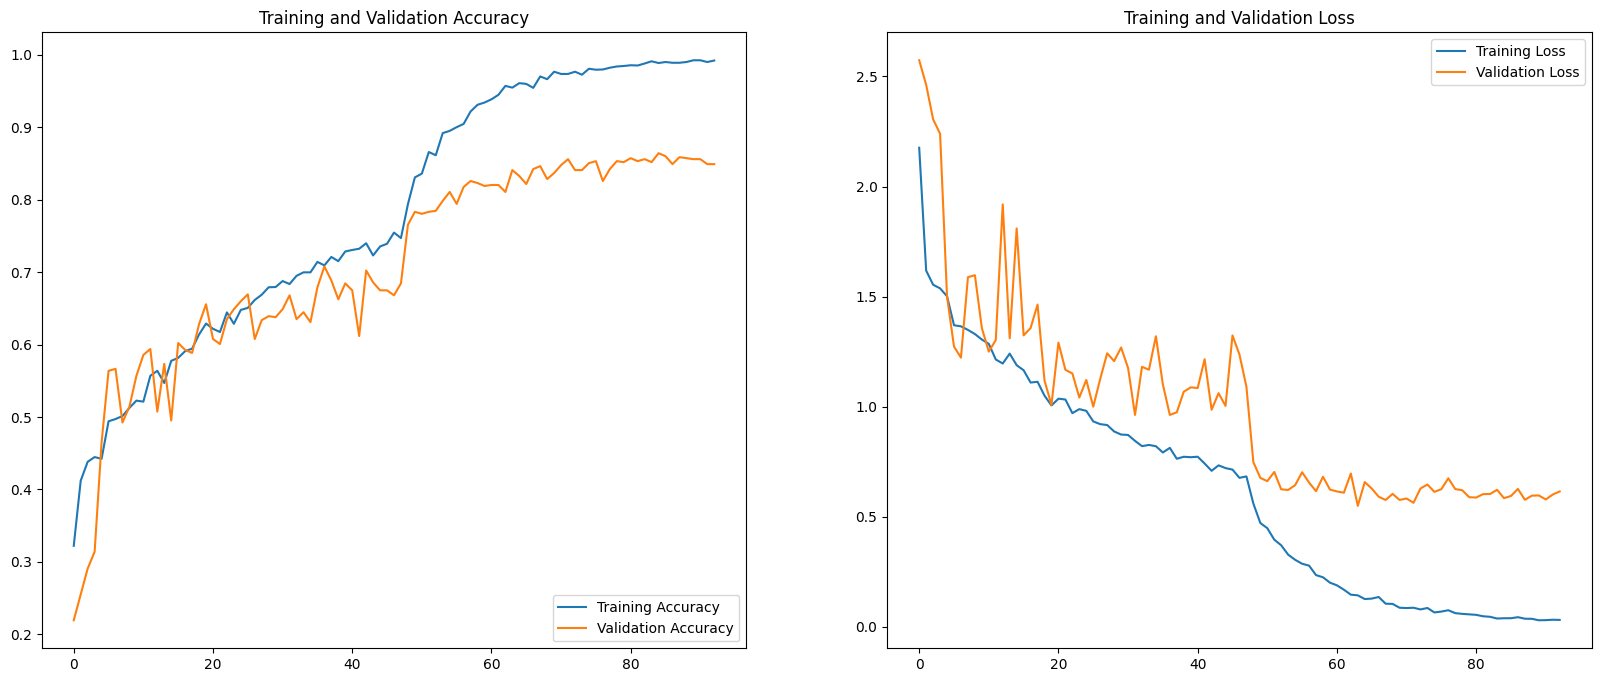

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, len(new_history)), new_history["accuracy"], label='Training Accuracy')
plt.plot(np.arange(0, len(new_history)), new_history["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, len(new_history)), new_history["loss"], label='Training Loss')
plt.plot(np.arange(0, len(new_history)), new_history["val_loss"], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*Significantly increase in convergence and accuracy: train accuracy ~99.93%, validation accuracy ~85% and test accuracy ~93%*

**=> Using ensemble learning with boosting method (train 2 models sequentially, so the latter model can learn how to fix the previous model's error): Small and simple dataset (non-aug) make the model's speed of learning faster, fix noise or complex data of previous train (with aug)**

## Pre-trained model
___

In [ ]:
def model_compile(model, file_name, sfe):
  callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', start_from_epoch= sfe), # mode in {'auto', 'min', 'max'}, patience: sau bao nhiêu epoch không có sự cải thiện thì dừng lại, mode='min': chỉ dừng lại khi loss không giảm dần, mode='max': chỉ dừng lại khi loss không tăng dần
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='min'), # factor: giảm learning rate bằng factor, patience: số lần không có sự cải thiện nào thì dừng lại, verbose: thông báo
    ModelCheckpoint(filepath="/content/drive/MyDrive/PBL5-Data/training1/"+file_name,
                                              save_weights_only=True,
                                              verbose=0)
  ] 

  model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate = 0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  model.summary()
  return model, callbacks

In [ ]:
# get Reset50V2
base_model = tf.keras.applications.ResNet50V2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights="imagenet")

# base_model.trainable = False
for layer in base_model.layers[:-4]:
  layer.trainable = False

# # construct a new network
# inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
# x = base_model(x)
# x = tf.keras.layers.GlobalMaxPool2D()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dense(8)(x)
# x = tf.keras.layers.Dropout(0.5)

# model = tf.keras.Model(inputs, x)

#
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    base_model,
    layers.GlobalMaxPool2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(8)
])
# summary
model, callbacks = model_compile(model, "checkpoint_ResNet50V2_after", 15)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                      

In [ ]:
epochs =100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = callbacks
)

Epoch 1/100
89/89 [==============================] - 20s 117ms/step - loss: 2.9794 - accuracy: 0.5870 - val_loss: 1.1390 - val_accuracy: 0.6761 - lr: 0.0010
Epoch 2/100
89/89 [==============================] - 7s 78ms/step - loss: 0.9518 - accuracy: 0.6959 - val_loss: 0.7174 - val_accuracy: 0.7634 - lr: 0.0010
Epoch 3/100
89/89 [==============================] - 9s 93ms/step - loss: 0.7802 - accuracy: 0.7283 - val_loss: 0.5505 - val_accuracy: 0.8028 - lr: 0.0010
Epoch 4/100
89/89 [==============================] - 8s 82ms/step - loss: 0.7135 - accuracy: 0.7604 - val_loss: 0.6059 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 5/100
89/89 [==============================] - 8s 89ms/step - loss: 0.6503 - accuracy: 0.7685 - val_loss: 0.5139 - val_accuracy: 0.8366 - lr: 0.0010
Epoch 6/100
89/89 [==============================] - 8s 86ms/step - loss: 0.6441 - accuracy: 0.7755 - val_loss: 0.5630 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 7/100
89/89 [==============================] - 7s 80ms/step - 

In [ ]:
save_hist(history, "hist_ResNet50V2_stratify_after")
model.save("/content/drive/MyDrive/PBL5-Data/training1/base_ResNet50V2")

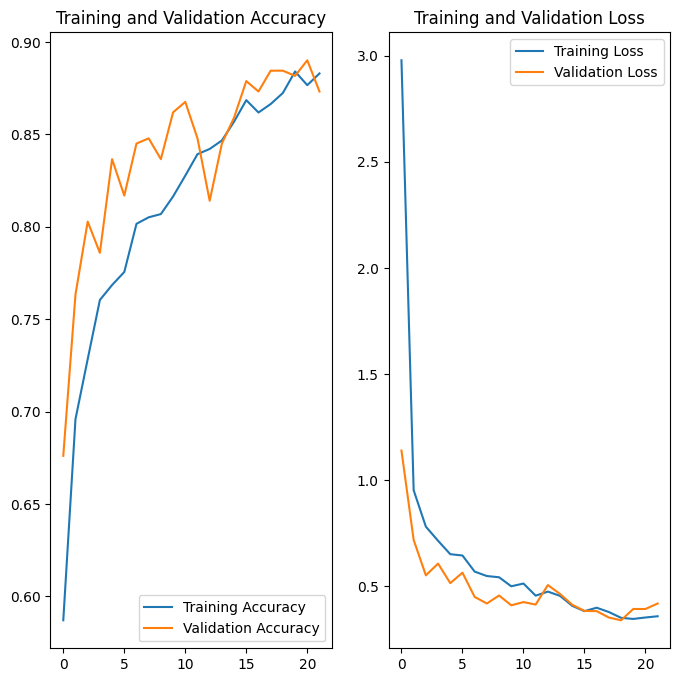

In [ ]:
loss_acc(history, 22)

12/12 [==============================] - 1s 49ms/step - loss: 0.5274 - accuracy: 0.8592


,train_ds,val_ds,test_ds
accuracy,0.931994,0.873239,0.859155
loss,0.195104,0.417796,0.527419


Inference_time:  41.16892910003662


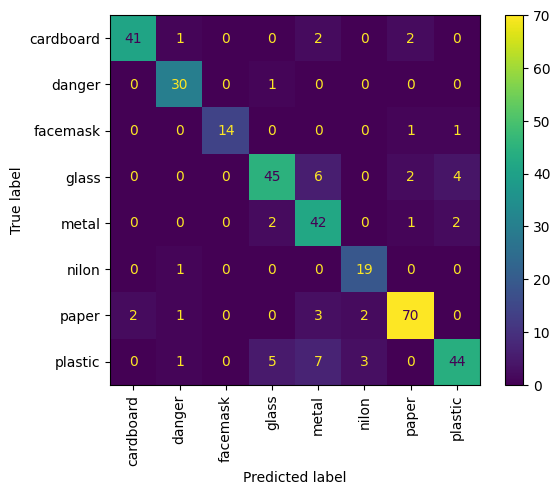

In [ ]:
evaluate_conma(model)

In [ ]:
# get MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights="imagenet")

# base_model.trainable = False
for layer in base_model.layers[:-4]:
  layer.trainable = False

# # construct a new network
# inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
# x = base_model(x)
# x = tf.keras.layers.GlobalMaxPool2D()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dense(8)(x)
# x = tf.keras.layers.Dropout(0.5)

# model = tf.keras.Model(inputs, x)

#
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    base_model,
    layers.GlobalMaxPool2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(8)
])
# summary
model, callbacks = model_compile(model, "checkpoint_MobileNetV2_T", 15)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1280)             

In [ ]:
epochs =100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = callbacks
)

Epoch 1/100
92/92 [==============================] - 17s 103ms/step - loss: 2.2966 - accuracy: 0.5264 - val_loss: 0.8683 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - 9s 96ms/step - loss: 0.9750 - accuracy: 0.6558 - val_loss: 0.7159 - val_accuracy: 0.7476 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - 8s 80ms/step - loss: 0.8197 - accuracy: 0.7172 - val_loss: 0.6859 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 4/100
92/92 [==============================] - 9s 94ms/step - loss: 0.7579 - accuracy: 0.7265 - val_loss: 0.5720 - val_accuracy: 0.7970 - lr: 0.0010
Epoch 5/100
92/92 [==============================] - 9s 95ms/step - loss: 0.6922 - accuracy: 0.7509 - val_loss: 0.5898 - val_accuracy: 0.7860 - lr: 0.0010
Epoch 6/100
92/92 [==============================] - 9s 96ms/step - loss: 0.6627 - accuracy: 0.7769 - val_loss: 0.5426 - val_accuracy: 0.8066 - lr: 0.0010
Epoch 7/100
92/92 [==============================] - 10s 91ms/step -

In [ ]:
save_hist(history, "hist_MobileNetV2")
model.save("/content/drive/MyDrive/PBL5-Data/training1/base_MobileNetV2")

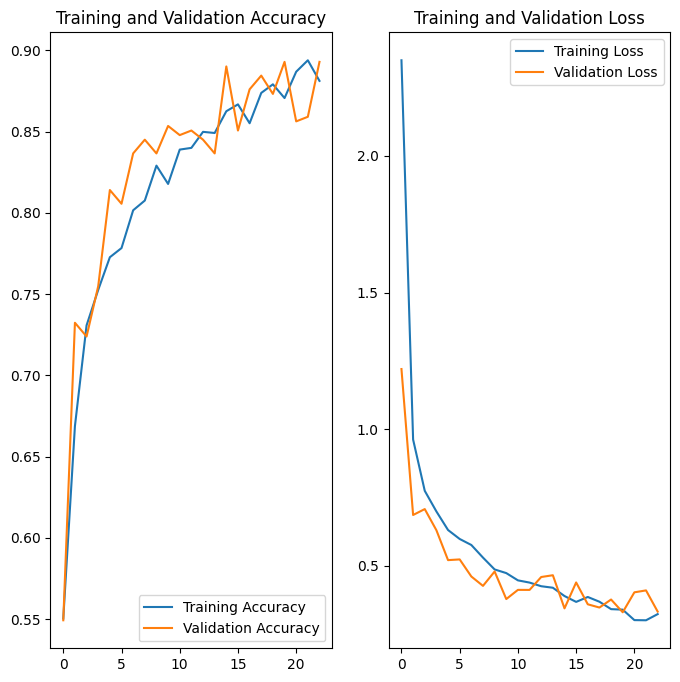

In [ ]:
loss_acc(history, 23)

11/11 [==============================] - 2s 96ms/step - loss: 0.2903 - accuracy: 0.8761


,train_ds,val_ds,test_ds
accuracy,0.924846,0.857339,0.876106
loss,0.214754,0.392389,0.290266


Inference_time:  26.742392539978027


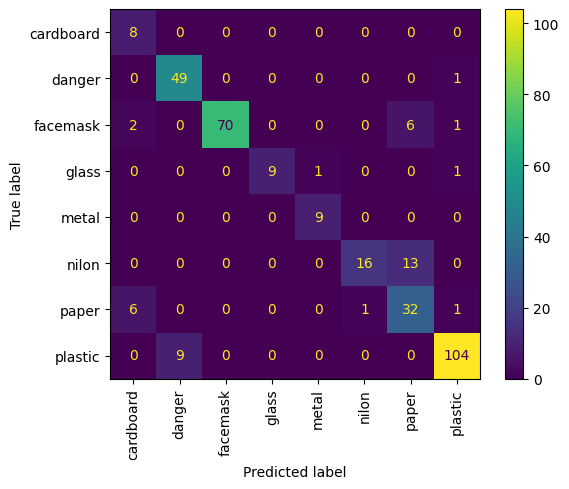

In [ ]:
evaluate_conma(model)

In [ ]:
# get DenseNet121
base_model = tf.keras.applications.DenseNet121(input_shape=(160,160,3),
                                               include_top=False,
                                               weights="imagenet")

# base_model.trainable = False
for layer in base_model.layers[:-4]:
  layer.trainable = False

# # construct a new network
# inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
# x = base_model(x)
# x = tf.keras.layers.GlobalMaxPool2D()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dense(8)(x)
# x = tf.keras.layers.Dropout(0.5)

# model = tf.keras.Model(inputs, x)

#
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    base_model,
    layers.GlobalMaxPool2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(8)
])
# summary
model, callbacks = model_compile(model, "checkpoint_DenseNet121", 15)

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1024)             0         
 balMaxPooling2D)                                                
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1024)              

In [ ]:
epochs =100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = callbacks
)

Epoch 1/100
89/89 [==============================] - 25s 147ms/step - loss: 2.0277 - accuracy: 0.4739 - val_loss: 0.8345 - val_accuracy: 0.7099 - lr: 0.0010
Epoch 2/100
89/89 [==============================] - 9s 95ms/step - loss: 1.0498 - accuracy: 0.6353 - val_loss: 0.6053 - val_accuracy: 0.7887 - lr: 0.0010
Epoch 3/100
89/89 [==============================] - 9s 98ms/step - loss: 0.9335 - accuracy: 0.6677 - val_loss: 0.5396 - val_accuracy: 0.7972 - lr: 0.0010
Epoch 4/100
89/89 [==============================] - 8s 83ms/step - loss: 0.8772 - accuracy: 0.6850 - val_loss: 0.5007 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 5/100
89/89 [==============================] - 9s 93ms/step - loss: 0.8017 - accuracy: 0.7153 - val_loss: 0.5259 - val_accuracy: 0.8282 - lr: 0.0010
Epoch 6/100
89/89 [==============================] - 9s 93ms/step - loss: 0.7730 - accuracy: 0.7322 - val_loss: 0.4709 - val_accuracy: 0.8451 - lr: 0.0010
Epoch 7/100
89/89 [==============================] - 8s 83ms/step - 

In [ ]:
save_hist(history, "hist_DenseNet121")
model.save("/content/drive/MyDrive/PBL5-Data/training1/base_DenseNet121")

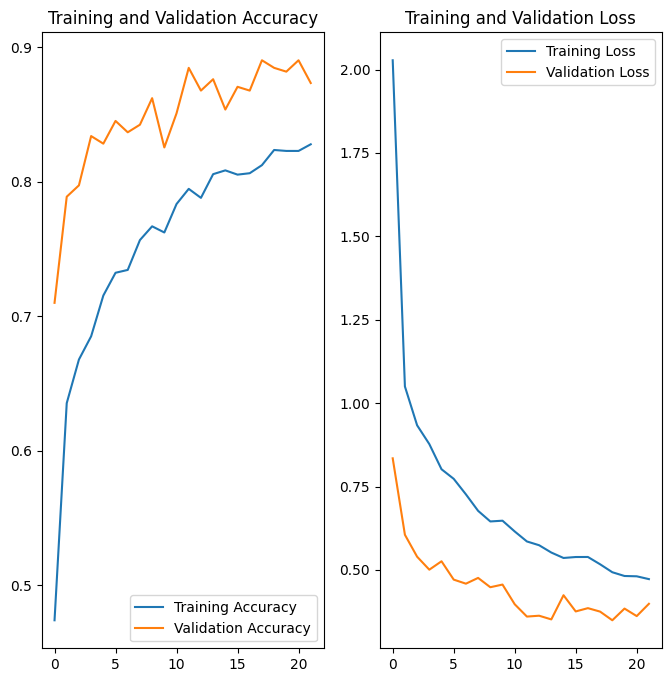

In [ ]:
loss_acc(history,22)

12/12 [==============================] - 1s 52ms/step - loss: 0.5867 - accuracy: 0.8085


,train_ds,val_ds,test_ds
accuracy,0.905567,0.873239,0.808451
loss,0.266507,0.398404,0.586676


Inference_time:  41.07917237281799


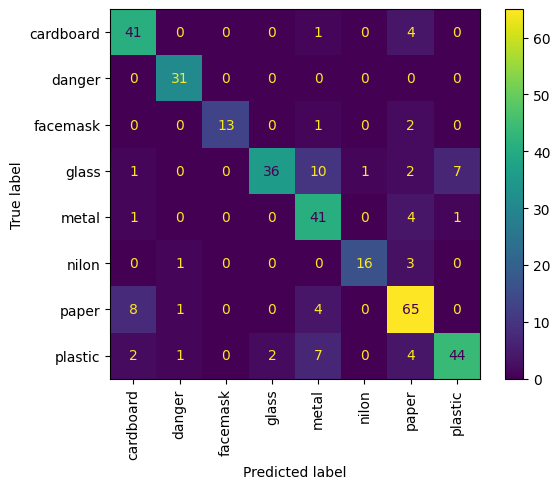

In [ ]:
evaluate_conma(model)